## Setup

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("style.mplstyle")
from preprocessing import get_models_and_soups_df

In [34]:
soups, models_df = get_models_and_soups_df()
# same_model_variant = soups[soups['variant_a'] == soups['variant_b']].copy()

In [35]:
soups['clean_loss'].max()

np.float64(4.864101571655273)

## Probability of souping being good

In [36]:
# Indicator for positive gain
soups['gain_positive'] = soups['soup_gain'] >= 0

# Probability of positive gain for each shared epoch count
prob_df = (
    soups
    .groupby('shared_epochs')['gain_positive']
    .mean()
    .reset_index()
    .rename(columns={'gain_positive': 'prob_positive_gain'})
)

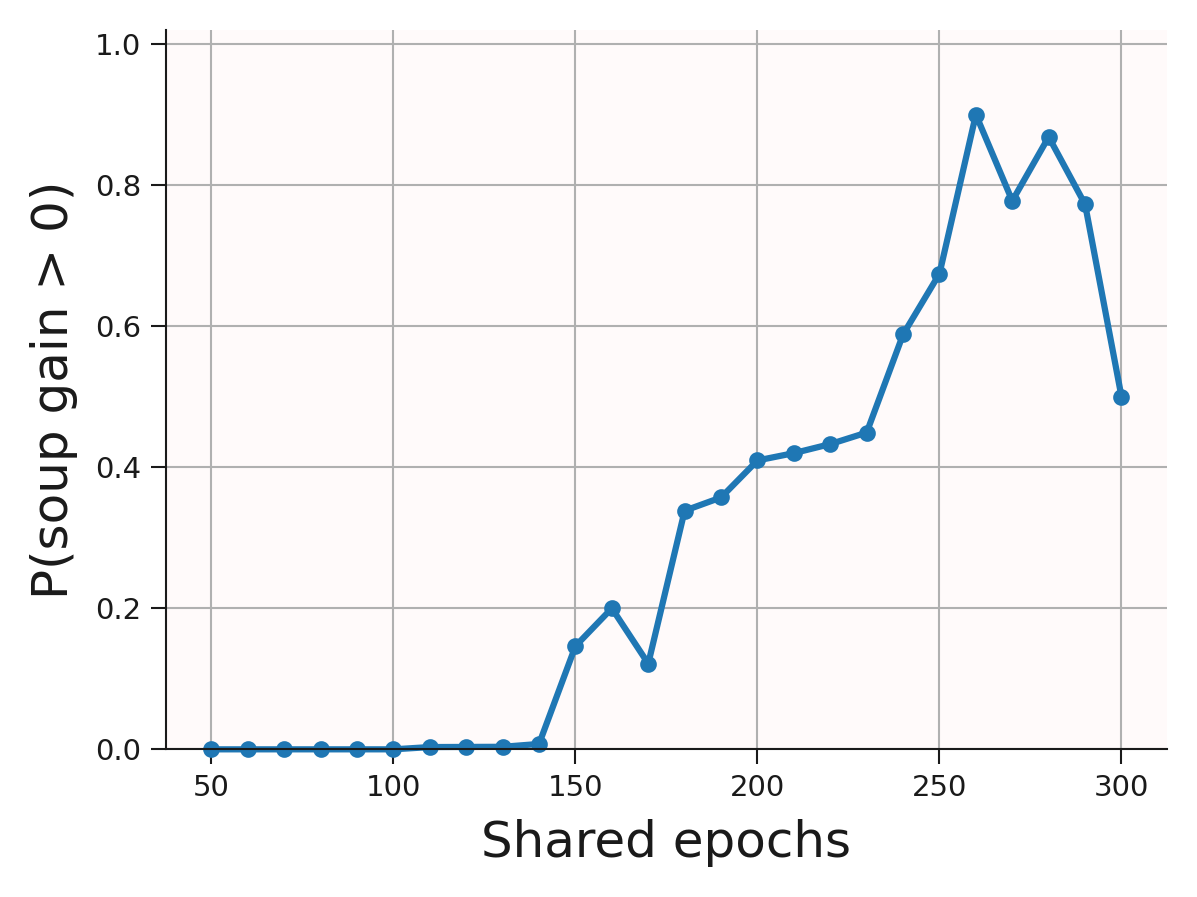

<Figure size 1200x900 with 0 Axes>

In [37]:
fig, ax = plt.subplots()

ax.plot(
    prob_df['shared_epochs'],
    prob_df['prob_positive_gain'],
    marker='o',
    markersize=3,
    clip_on=False
)

ax.set_xlabel('Shared epochs', fontsize=12)
ax.set_ylabel('P(soup gain > 0)', fontsize=12)
# ax.set_title('Probability of positive soup gain vs shared epochs', fontsize=13)

ax.set_ylim(0, 1.02)

plt.tight_layout()
plt.show()
plt.savefig('../iclr_report/figures/prob_positive_gain_vs_shared_epochs.pdf')

## Mean soup Gain

In [38]:
mean_gain_df = (
    soups
    .groupby('shared_epochs')['soup_gain']
    .mean()
    .reset_index()
    .rename(columns={'soup_gain': 'mean_soup_gain'})
)

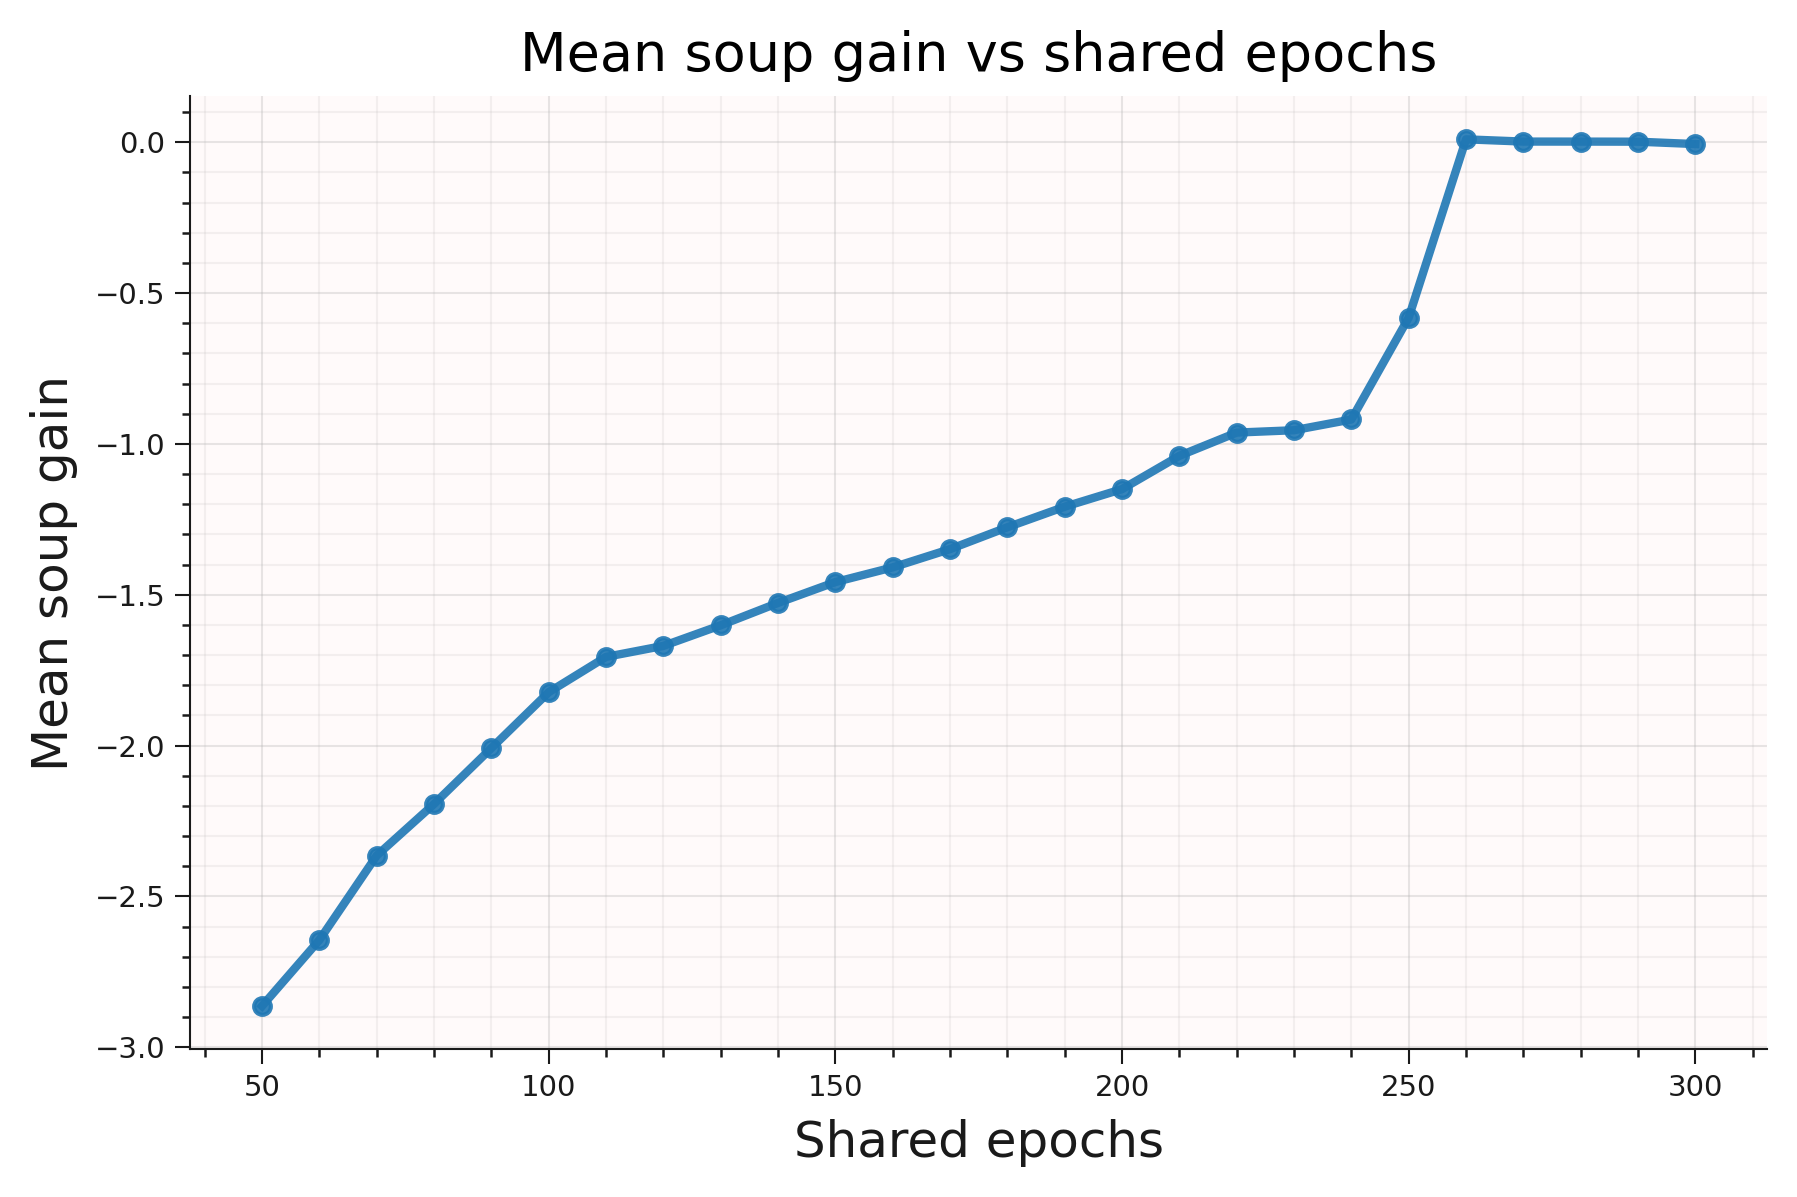

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    mean_gain_df['shared_epochs'],
    mean_gain_df['mean_soup_gain'],
    marker='o',
    markersize=4,
    linewidth=2,
    alpha=0.9
)

ax.set_xlabel('Shared epochs', fontsize=12)
ax.set_ylabel('Mean soup gain', fontsize=12)
ax.set_title('Mean soup gain vs shared epochs', fontsize=13)

# Light gridlines
ax.grid(True, which='major', alpha=0.3)
ax.minorticks_on()
ax.grid(True, which='minor', alpha=0.15)

plt.tight_layout()
plt.show()
# plt.savefig('../report/figures/mean_soup_gain_vs_shared_epochs.pdf')

## Soup quantiles

In [40]:
q_df = (
    soups
    .groupby('shared_epochs')['soup_gain']
    .quantile([0.1, 0.5, 0.9])
    .unstack()
    .rename(columns={0.1: 'q10', 0.5: 'median', 0.9: 'q90'})
    .reset_index()
)


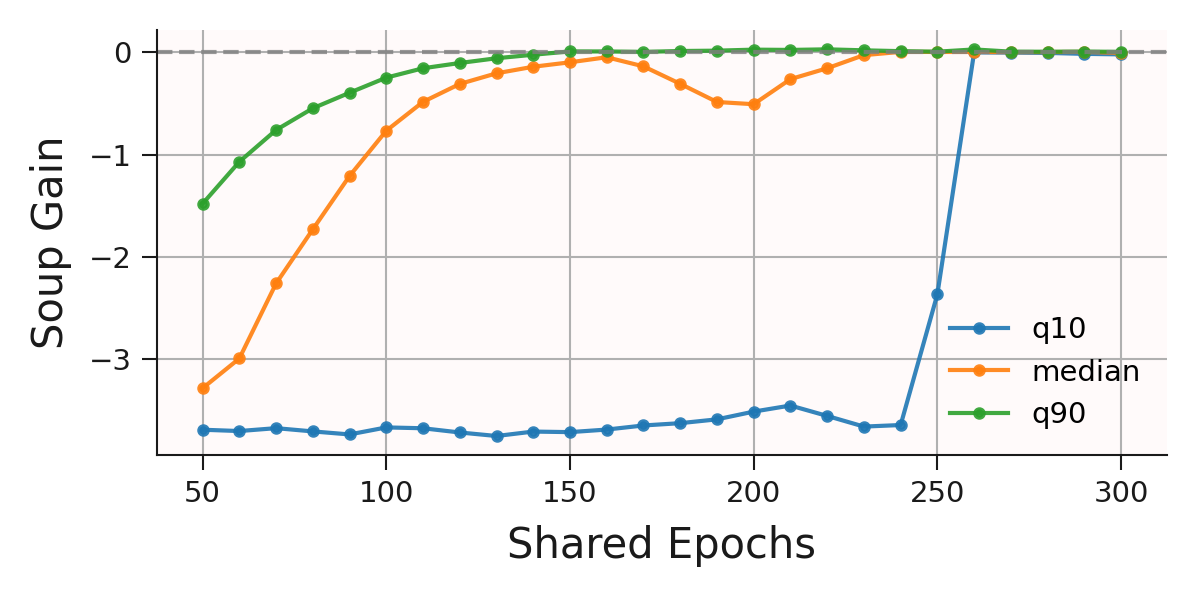

In [41]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(
    q_df['shared_epochs'],
    q_df['q10'],
    label='q10',
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9
)

ax.plot(
    q_df['shared_epochs'],
    q_df['median'],
    label='median',
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9
)

ax.plot(
    q_df['shared_epochs'],
    q_df['q90'],
    label='q90',
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9
)

ax.axhline(0, linewidth=1, alpha=0.8, color='gray', linestyle='--')

ax.set_xlabel('Shared Epochs', fontsize=10)
ax.set_ylabel('Soup Gain', fontsize=10)
# ax.set_title('Quantiles of soup gain vs shared epochs', fontsize=13)

# ax.grid(True, which='major', alpha=0.3)
# ax.minorticks_on()
# ax.grid(True, which='minor', alpha=0.15)

ax.legend(frameon=False)

plt.tight_layout()
plt.savefig('../iclr_report/figures/soup_gain_quantiles_vs_shared_epochs.pdf')
plt.show()

## Conditional expected souping performance +ve/-ve

In [42]:
soups["soup_gain_acc"] = soups["clean_accuracy"] - soups[["clean_accuracy_a", "clean_accuracy_b"]].max(axis=1)

In [43]:
three_df = (
    soups
    .assign(is_pos = soups['soup_gain_acc'] > 0)
    .groupby('shared_epochs')
    .agg(
        p_pos = ('is_pos', 'mean'),
        mean_pos = ('soup_gain_acc', lambda x: x[x > 0].mean()),
        mean_neg = ('soup_gain_acc', lambda x: x[x < 0].mean()),
    )
    .reset_index()
)

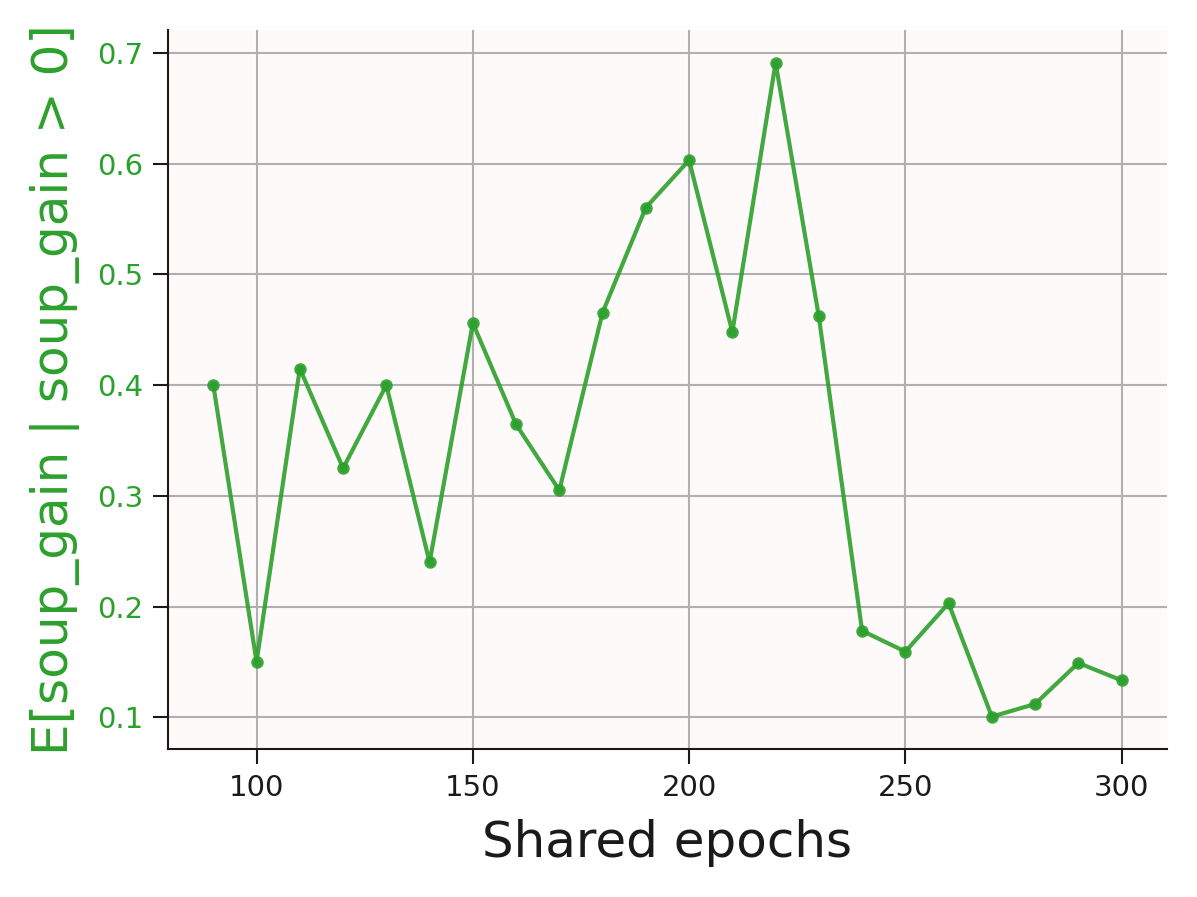

<Figure size 1200x900 with 0 Axes>

In [44]:
fig, ax1 = plt.subplots()

ax1.plot(
    three_df['shared_epochs'],
    three_df['mean_pos'],
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9,
    color='tab:green',
    label='E[gain | gain > 0]'
)
ax1.set_ylabel('E[soup_gain | soup_gain > 0]', fontsize=12, color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

ax1.set_xlabel('Shared epochs', fontsize=12)

plt.tight_layout()
plt.show()
plt.savefig('../report/figures/souping_conditional_gain_vs_shared_epochs.pdf')

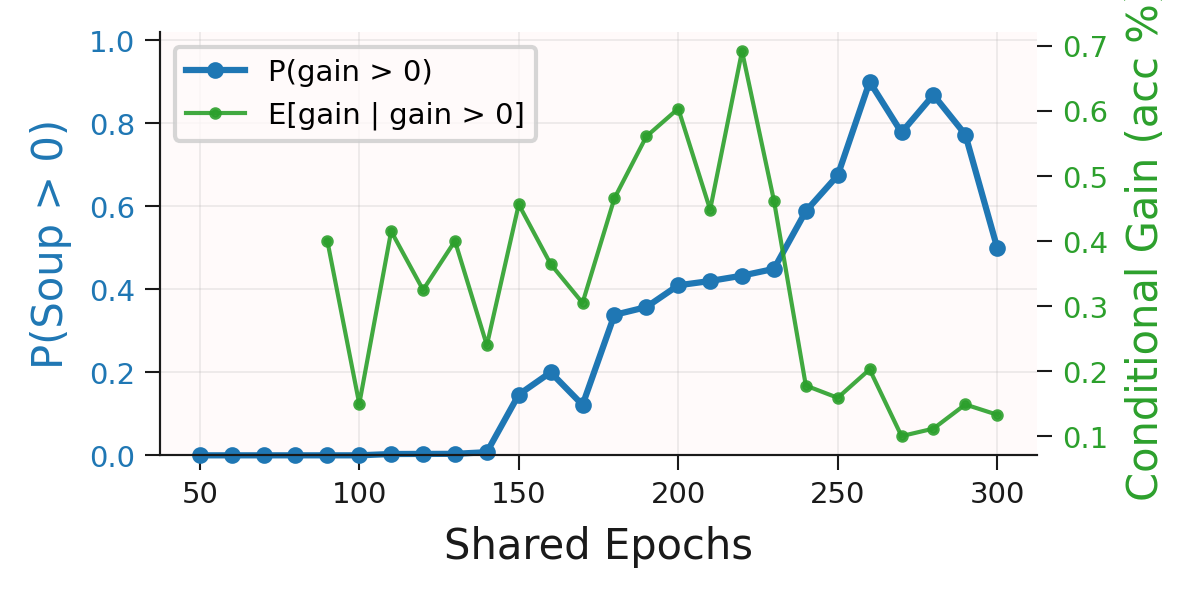

In [45]:
fig, ax1 = plt.subplots(figsize=(4,2))

# Left axis: probability
ax1.plot(
    prob_df['shared_epochs'],
    prob_df['prob_positive_gain'],
    marker='o',
    markersize=3,
    clip_on=False,
    color='tab:blue',
    label='P(gain > 0)'
)

ax1.set_xlabel('Shared Epochs', fontsize=10)
ax1.set_ylabel('P(Soup > 0)', fontsize=10, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1.02)

# Clean, subtle grid
ax1.grid(True, which='both', axis='both', linestyle='-', linewidth=0.4, alpha=0.25)

# Right axis
ax2 = ax1.twinx()

ax2.plot(
    three_df['shared_epochs'],
    three_df['mean_pos'],
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9,
    color='tab:green',
    label='E[gain | gain > 0]'
)

ax2.set_ylabel('Conditional Gain (acc %)', fontsize=10, color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Disable right-axis grid to avoid clutter
ax2.grid(False)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('../iclr_report/figures/combined_prob_and_conditional_gain.pdf')
plt.show()

## Probability of model collapse

In [46]:
# Indicators
soups['is_collapse'] = soups['clean_accuracy'] < 70
soups['gain_negative'] = soups['soup_gain'] < 0

prob_df = (
    soups
    .groupby('shared_epochs')
    .agg(
        p_collapse = ('is_collapse', 'mean'),
        p_neg_gain = ('gain_negative', 'mean')
    )
    .reset_index()
)


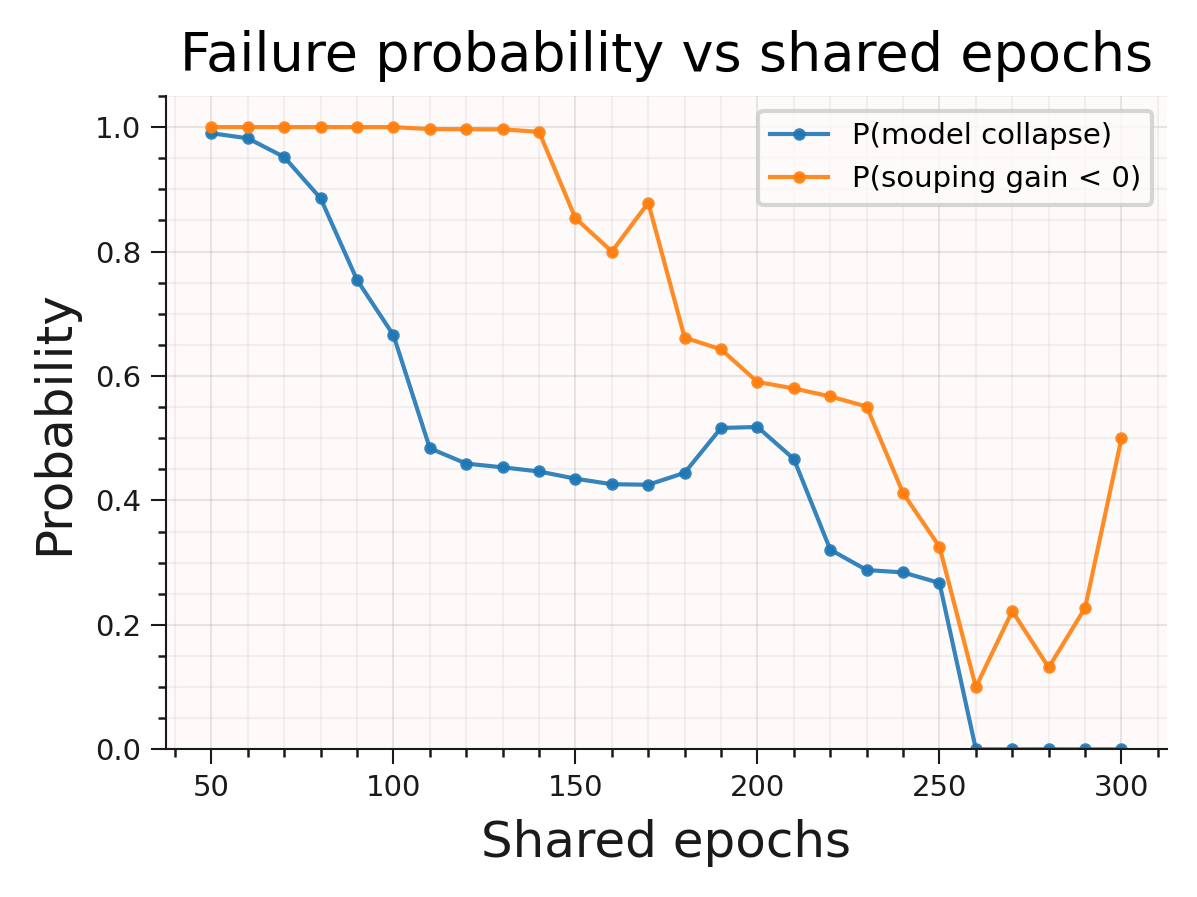

<Figure size 1200x900 with 0 Axes>

In [47]:
fig, ax = plt.subplots()

ax.plot(
    prob_df['shared_epochs'],
    prob_df['p_collapse'],
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9,
    label='P(model collapse)'
)

ax.plot(
    prob_df['shared_epochs'],
    prob_df['p_neg_gain'],
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9,
    label='P(souping gain < 0)'
)

ax.set_xlabel('Shared epochs', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Failure probability vs shared epochs', fontsize=13)

ax.set_ylim(0, 1.05)

ax.grid(True, which='major', alpha=0.3)
ax.minorticks_on()
ax.grid(True, which='minor', alpha=0.15)

ax.legend()

plt.tight_layout()
plt.show()
plt.savefig('../iclr_report/figures/model_collapse_vs_shared_epochs.pdf')